<a href="https://colab.research.google.com/github/pedro-varela1/Demented_Adults_Prediction/blob/main/Demented_Adults_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de Adultos com Demência baseado em dados de MRI (Ressonância Magnética)

- By: Pedro Varela

---

In [ ]:
!pip install tensorflow_decision_forests

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Análise do Dataset

In [3]:
cross_sectional_filepath = "/content/oasis_cross-sectional.csv"
longitudinal_filepath = "/content/oasis_longitudinal.csv"

df_cross = pd.read_csv(cross_sectional_filepath)
df_cross.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [4]:
df_longitudinal = pd.read_csv(longitudinal_filepath)
df_longitudinal.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Primeiramente, vamos atentar para o dataframe ```df_longitudinal```.

Vamos mudar o index para a coluna _MRI ID_ e descartar a coluna _Subject ID_, já que ela não é um _label_ nem uma _feature_.

In [5]:
df_longitudinal.set_index('MRI ID', inplace=True)

df_longitudinal.drop('Subject ID', axis='columns', inplace=True)

df_longitudinal.head()

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,
OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


É importante coletar algumas informações do dataframe.

In [6]:
df_longitudinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, OAS2_0001_MR1 to OAS2_0186_MR3
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Group     373 non-null    object 
 1   Visit     373 non-null    int64  
 2   MR Delay  373 non-null    int64  
 3   M/F       373 non-null    object 
 4   Hand      373 non-null    object 
 5   Age       373 non-null    int64  
 6   EDUC      373 non-null    int64  
 7   SES       354 non-null    float64
 8   MMSE      371 non-null    float64
 9   CDR       373 non-null    float64
 10  eTIV      373 non-null    int64  
 11  nWBV      373 non-null    float64
 12  ASF       373 non-null    float64
dtypes: float64(5), int64(5), object(3)
memory usage: 40.8+ KB


Vamos analisar nosso _label_, que é se o indivíduo possui demência ou não.

In [7]:
df_longitudinal['Group'].value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

Vamos nos livrar das linhas que tem indivíduos cujo label é _Converted_.

In [8]:
i = df_longitudinal[df_longitudinal['Group']=='Converted'].index
df_longitudinal.drop(i, inplace=True)

df_longitudinal['Group'].value_counts()

Nondemented    190
Demented       146
Name: Group, dtype: int64

É importante analisar as _features_ numéricas.

In [9]:
df_num = df_longitudinal.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,
OAS2_0001_MR1,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001_MR2,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002_MR1,1,0,75,12,NaN,23.0,0.5,1678,0.736,1.046
OAS2_0002_MR2,2,560,76,12,NaN,28.0,0.5,1738,0.713,1.010
OAS2_0002_MR3,3,1895,80,12,NaN,22.0,0.5,1698,0.701,1.034


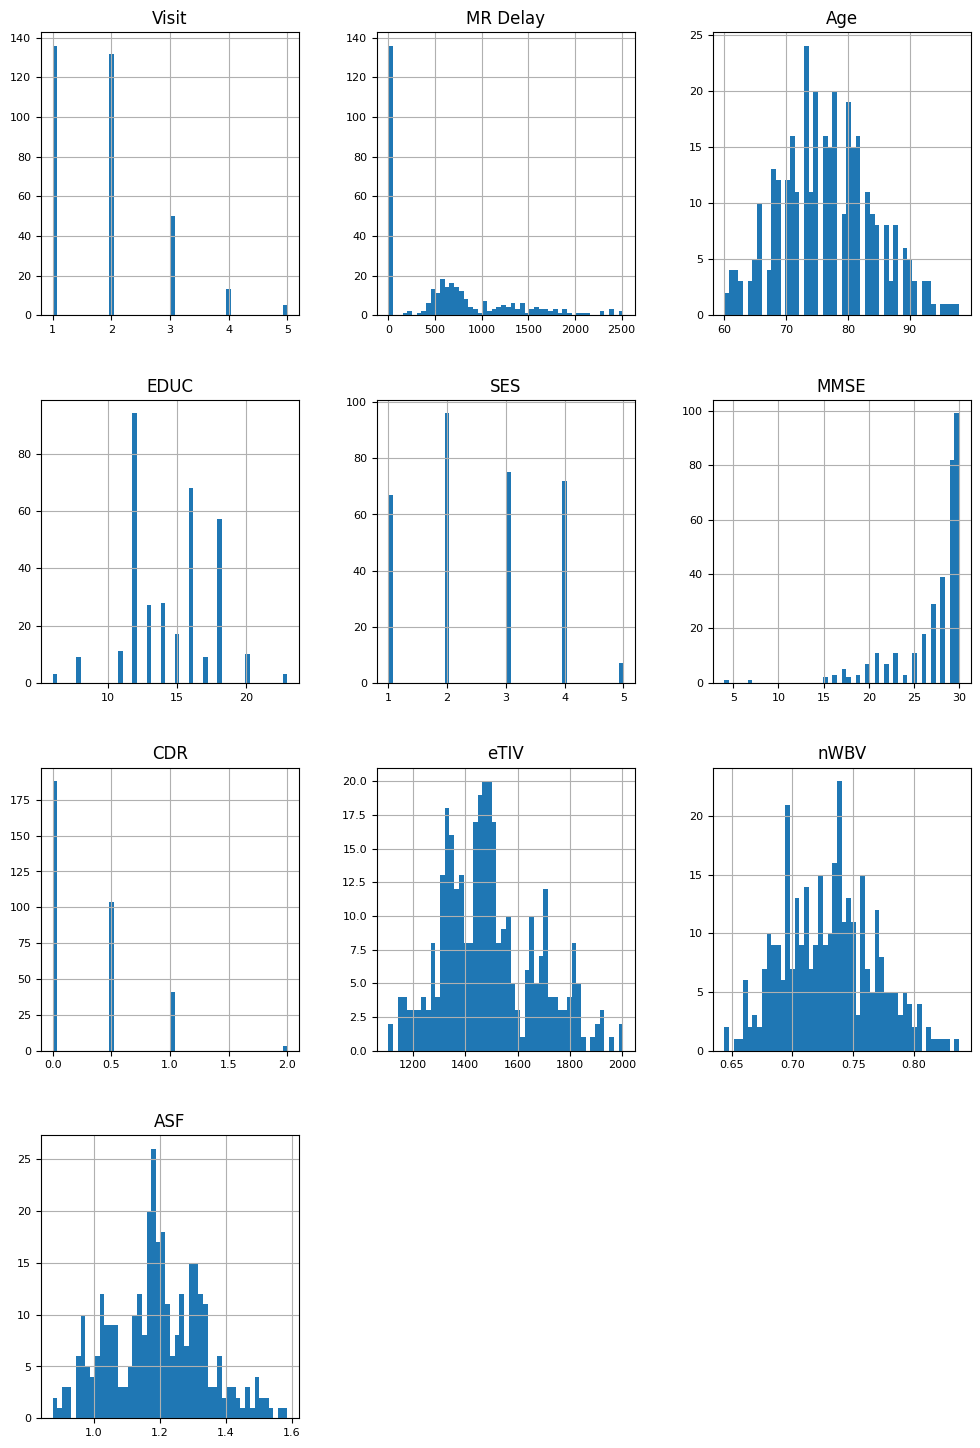

In [10]:
df_num.hist(figsize=(12, 18), bins=50, xlabelsize=8, ylabelsize=8);

Vamos transformar o label em 1 para os indivíduos dementes e 0 para os indivíduos normais.

In [11]:
df_longitudinal['Group'] = df_longitudinal.apply(
    lambda x: 1 if (x['Group']=='Demented') else 0,
    axis=1
    )
df_longitudinal.head()

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
MRI ID,,,,,,,,,,,,,
OAS2_0001_MR1,0,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001_MR2,0,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002_MR1,1,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
OAS2_0002_MR2,1,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
OAS2_0002_MR3,1,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [12]:
df_longitudinal['Group'].value_counts()

0    190
1    146
Name: Group, dtype: int64

Por fim, antes de aplicar o modelo, vamos dividir o dataset em 80% para o treinamento e 20% para validação.

In [13]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df_longitudinal)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

227 examples in training, 109 examples in testing.


## O modelo _Random Florest_ da Floresta de Decisão

O dataframe tem que ser transformado no formato do tensorflow para o modelo de Regressão.

In [14]:
label = 'Group'

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

O modelo precisa ser criado.

In [15]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmpl1jvs1yo as temporary training directory


Vamos treinar o modelo.

In [16]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:14.099460. Found 227 examples.
Training model...
Model trained in 0:00:00.316483
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


Vamos checar algumas ramificações.

In [17]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

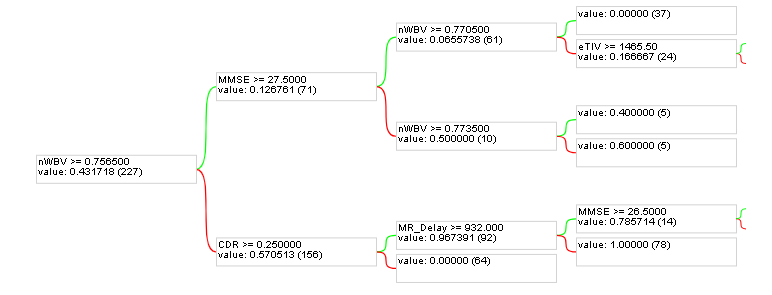

In [18]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=200, max_depth=3)

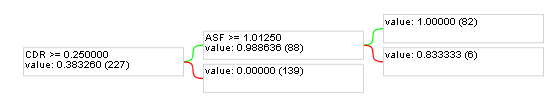

Vamos para a validação.

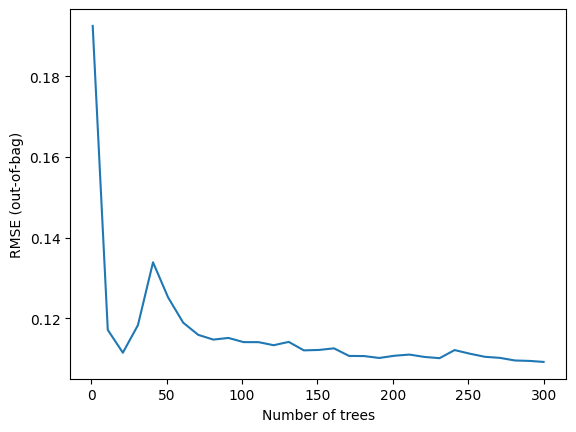

In [19]:
import matplotlib.pyplot as plt

logs = rf.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [20]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 689ms/step - loss: 0.0000e+00 - mse: 0.0040
loss: 0.0000
mse: 0.0040


In [21]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=227, accuracy=None, loss=None, rmse=0.10915428095329903, ndcg=None, aucs=None, auuc=None, qini=None)

### Variáveis de Importância

In [22]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT


In [23]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("CDR" (1; #2), 142.0),
 ("MMSE" (1; #6), 77.0),
 ("nWBV" (1; #12), 34.0),
 ("MR_Delay" (1; #7), 21.0),
 ("M/F" (4; #5), 12.0),
 ("EDUC" (1; #3), 8.0),
 ("SES" (1; #8), 2.0),
 ("eTIV" (1; #11), 2.0),
 ("ASF" (1; #0), 1.0),
 ("Visit" (1; #9), 1.0)]

Vamos fazer uma plotagem para melhor visualização.

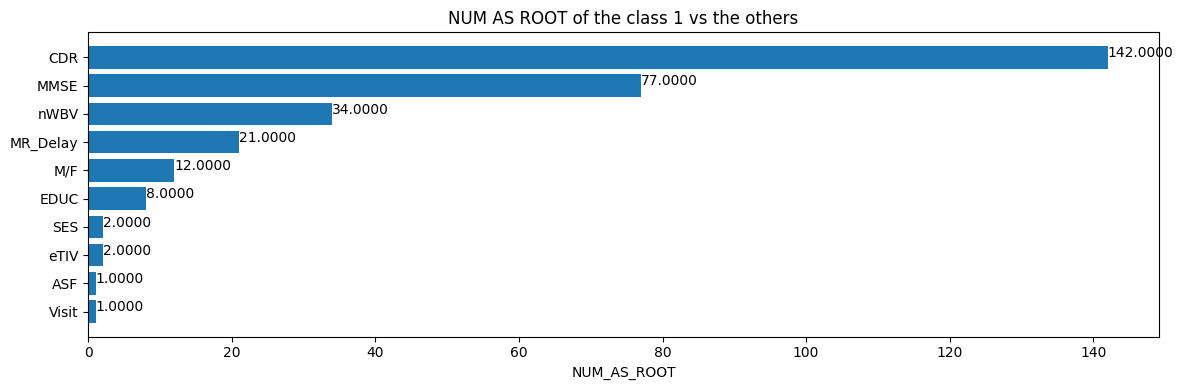

In [24]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

## Comparação Percentual com todos os dados

In [25]:
test_file_path = "/content/oasis_longitudinal.csv"
test_data = pd.read_csv(test_file_path)

test_data.drop('Subject ID', axis='columns', inplace=True)
ids = test_data.pop('MRI ID')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'MRI ID': ids,
                       'Group': preds.squeeze()})

output.head()

1/1 [==============================] - 0s 202ms/step


,MRI ID,Group
0,OAS2_0001_MR1,0.133991
1,OAS2_0001_MR2,0.053934
2,OAS2_0002_MR1,0.991221
3,OAS2_0002_MR2,0.896376
4,OAS2_0002_MR3,0.939748


In [26]:
output.set_index('MRI ID', inplace=True)
output.head()

,Group
MRI ID,
OAS2_0001_MR1,0.133991
OAS2_0001_MR2,0.053934
OAS2_0002_MR1,0.991221
OAS2_0002_MR2,0.896376
OAS2_0002_MR3,0.939748


In [27]:
output['Group'] = output.apply(
    lambda x: 1 if (x['Group']>0.5) else 0,
    axis=1
    )
output.head()

,Group
MRI ID,
OAS2_0001_MR1,0
OAS2_0001_MR2,0
OAS2_0002_MR1,1
OAS2_0002_MR2,1
OAS2_0002_MR3,1


Vamos mudar o nome da coluna.

In [28]:
output.rename(columns={"Group": "prediction"}, inplace=True)
output.head()

,prediction
MRI ID,
OAS2_0001_MR1,0
OAS2_0001_MR2,0
OAS2_0002_MR1,1
OAS2_0002_MR2,1
OAS2_0002_MR3,1


Vamos juntar as predições com o dataframe original.

In [29]:
df_longitudinal = df_longitudinal.join(output)
df_longitudinal.head()

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,prediction
MRI ID,,,,,,,,,,,,,,
OAS2_0001_MR1,0,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883,0
OAS2_0001_MR2,0,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876,0
OAS2_0002_MR1,1,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046,1
OAS2_0002_MR2,1,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010,1
OAS2_0002_MR3,1,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034,1


Vamos olhar a porcentagens de predições certas no total.

In [30]:
valid_predictions = len(df_longitudinal.loc[lambda df: df['Group'] == df['prediction'], ['Group']])

invalid_predictions = len(df_longitudinal.loc[lambda df: df['Group'] != df['prediction'], ['Group']])

print("{} valid prediction and {} invalid_predictions.".format(
    valid_predictions, invalid_predictions))

334 valid prediction and 2 invalid_predictions.


In [31]:
df_longitudinal.loc[lambda df: df['Group'] != df['prediction']]

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,prediction
MRI ID,,,,,,,,,,,,,,
OAS2_0005_MR2,0,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032,1
OAS2_0017_MR3,0,3,617,M,R,81,12,3.0,27.0,0.5,1814,0.759,0.968,1


In [32]:
print("Houveram {:2.3%} de predições válidas analisando todo o dataset.".format(
    valid_predictions/(valid_predictions+invalid_predictions)))

Houveram 99.405% de predições válidas analisando todo o dataset.
